In [50]:
import _tskit
import tskit

import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/szhan/Projects/tskit/python/tests/")
import beagle_numba

sys.path.append("/Users/szhan/Projects/tsimpute/src/")
import impute_by_sample_matching as tsimpute
import parallelise


In [2]:
in_dir = "/Users/szhan/Projects/tsimpute/notebooks/"
prefix = "jacobs_ceu_ceu_2k"


In [3]:
#ref_ts_file = in_dir + "/" + prefix + ".ref.trees"
ref_ts_file = "./jacobs_ceu_ceu_2k/default.inferred.trees"
ref_ts = tskit.load(ref_ts_file)
ref_ts


In [7]:
npy_query_file = in_dir + "/" + prefix + ".query.npy"
with open(npy_query_file, 'rb') as f:
    ts_query_h = np.load(f)
    ts_query_h_masked = np.load(f)
    genotyped_markers = np.load(f)
    ungenotyped_markers = np.load(f)
    genotyped_site_pos = np.load(f)
    ungenotyped_site_pos = np.load(f)


In [8]:
ref_ts_m = ref_ts.delete_sites(site_ids=ungenotyped_markers)
ref_ts_x = ref_ts.delete_sites(site_ids=genotyped_markers)
ref_h_x = ref_ts_x.genotype_matrix(alleles=tskit.ALLELES_ACGT)


### Impute a la BEAGLE

In [ ]:
# ACGT encoding
query_h_m = ts_query_h[genotyped_markers, :].T
print(query_h_m.shape)


In [ ]:
mu = beagle_numba.get_mismatch_prob(genotyped_site_pos, miscall_rate=1e-8)
rho = beagle_numba.get_switch_prob(genotyped_site_pos, h=ref_ts.num_samples, ne=10_000.0)
rho /= 1e5

alleles = np.arange(4)
imputed_alleles = np.zeros((query_h_m.shape[0], len(ungenotyped_markers)), dtype=np.int32)
max_allele_probs = np.zeros((query_h_m.shape[0], len(ungenotyped_markers)), dtype=np.float64)

for i in np.arange(query_h_m.shape[0]):
    fm = _tskit.CompressedMatrix(ref_ts_m._ll_tree_sequence)
    bm = _tskit.CompressedMatrix(ref_ts_m._ll_tree_sequence)
    # WARN: Change allele encoding.
    ls_hmm = _tskit.LsHmm(ref_ts_m._ll_tree_sequence, mu, rho, acgt_alleles=True)
    ls_hmm.forward_matrix(query_h_m[i, :], fm)
    ls_hmm.backward_matrix(query_h_m[i, :], fm.normalisation_factor, bm)
    sm = beagle_numba.compute_state_probability_matrix(
        fm.decode(),
        bm.decode(),
    )
    ap = beagle_numba.interpolate_allele_probabilities(
        sm,
        ref_h_x,
        alleles,
        genotyped_site_pos,
        ungenotyped_site_pos,
    )
    ia, map = beagle_numba.get_map_alleles(ap)
    imputed_alleles[i, :] = ia
    max_allele_probs[i, :] = map


### Impute using the Viteri path

In [45]:
mu = beagle_numba.get_mismatch_prob(ref_ts.sites_position, miscall_rate=1e-8)
rho = beagle_numba.get_switch_prob(ref_ts.sites_position, h=ref_ts.num_samples, ne=10_000.0)
rho /= 1e5

H1 = ts_query_h_masked.T
print(H1.shape)

H2 = np.zeros_like(H1)

def wrapper_get_traceback_path(arg):
    H2 = tsimpute.get_traceback_path(
        ts=arg['ts'],
        sample_sequence=arg['H1'],
        recombination_rates=arg['switch_prob'],
        mutation_rates=arg['mismatch_prob'],
        precision=arg['precision'],
    )
    return H2

H2_args = []
for i in np.arange(H1.shape[0]):
    H2_args.append({'ts': ref_ts, 'H1': H1[i, :], 'switch_prob': rho, 'mismatch_prob': mu, 'precision': 25})

parallel_runs = parallelise.threaded_map(wrapper_get_traceback_path, H2_args, 6)
for i, result in enumerate(parallel_runs):
    H2[i, :] = result


(1000, 72001)


In [46]:
H3 = tsimpute.impute_samples(ref_ts, H2)


100%|██████████| 72001/72001 [00:01<00:00, 50234.61it/s]


In [47]:
# Change file name
npy_results_file = prefix + ".ts_imputed.inferred_genealogy.results.npy"
with open(npy_results_file, 'wb') as f:
    #np.save(f, imputed_alleles)
    #np.save(f, max_allele_probs)
    np.save(f, H1)
    np.save(f, H2)
    np.save(f, H3)
    np.save(f, genotyped_markers)
    np.save(f, ungenotyped_markers)
    np.save(f, genotyped_site_pos)
    np.save(f, ungenotyped_site_pos)


### Compare imputation results

In [ ]:
# Subset to ungenotyped markers in groundtruth data.
query_h_truth = ts_query_h[ungenotyped_markers, :].T
assert not np.any(query_h_truth == -1)
assert query_h_truth.shape[0] == imputed_alleles.shape[0]

# Count number of wrongly imputed sites per query haplotype
num_diff_sites_beagle = np.zeros(query_h_truth.shape[0], dtype=np.int32) - 1
for i in np.arange(query_h_truth.shape[0]):
    num_diff_sites_beagle[i] = np.sum(
        np.invert(np.equal(query_h_truth[i, :], imputed_alleles[i, :]))
    )


In [48]:
# Subset to ungenotyped markers in groundtruth data.
query_h_truth = ts_query_h[ungenotyped_markers, :].T
assert not np.any(query_h_truth == -1)
H3_ungenotyped = H3[:, ungenotyped_markers]
assert query_h_truth.shape[0] == H3_ungenotyped.shape[0]

# Count number of wrongly imputed sites per query haplotype.
num_diff_sites_path = np.zeros(query_h_truth.shape[0], dtype=np.int32) - 1
for i in np.arange(query_h_truth.shape[0]):
    num_diff_sites_path[i] = np.sum(
        np.invert(np.equal(query_h_truth[i, :], H3_ungenotyped[i, :]))
    )


In [ ]:
plt.hist(num_diff_sites_beagle, bins=100)
plt.title("a la BEAGLE")
plt.ylabel("Number of query haplotypes")
plt.xlabel("Number of incorrectly imputed sites");


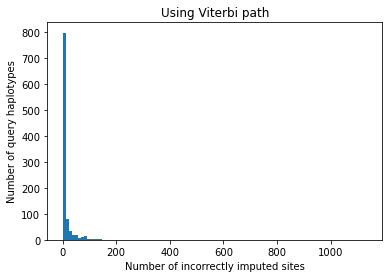

In [51]:
plt.hist(num_diff_sites_path, bins=100)
plt.title("Using Viterbi path")
plt.ylabel("Number of query haplotypes")
plt.xlabel("Number of incorrectly imputed sites");


In [ ]:
plt.scatter(
    y=num_diff_sites_beagle,
    x=num_diff_sites_path
)
plt.title("Number of incorrectly imputed sites")
plt.ylabel("a la BEAGLE")
plt.xlabel("Using Viterbi path");


In [52]:
#print(np.mean(num_diff_sites_beagle))
print(np.mean(num_diff_sites_path))


11.625


In [ ]:
print(f"Equally good: {np.sum(num_diff_sites_beagle == num_diff_sites_path)}")
print(f"a la BEAGLE is better: {np.sum(num_diff_sites_beagle < num_diff_sites_path)}")
print(f"a la BEAGLE is worse: {np.sum(num_diff_sites_beagle > num_diff_sites_path)}")
